In [27]:
import os
import glob
import json
import cv2
import numpy as np                  
import pandas as pd
import matplotlib.pyplot as plt
from PIL import Image
from tqdm.auto import tqdm

In [47]:
# Input
TRAIN_CSV_RSNA_PATH = "./input/train_rsna.csv"
TRAIN_CSV_INBREAST_PATH = "./input/train_inbreast.xls"
TRAIN_CSV_INBREAST_META_PATH = "./input/train_inbreast_metadata.csv"
TRAIN_CSV_CMMD_PATH = "./input/train_cmmd.csv"

TRAIN_INPUT_IMG_RSNA_PATH = "./images_rsna/"
TRAIN_INPUT_IMG_INBREAST_PATH = "./images_inbreast/"
TRAIN_INPUT_IMG_CMMD_PATH = "./images_cmmd/"

# Output
DATASET_NAME = f"RSNA+INBREAST"
SAVE_FOLDER = f"./output/{DATASET_NAME}"

In [29]:
df_train_rsna = pd.read_csv(TRAIN_CSV_RSNA_PATH)
print("-------------- RSNA -------------")
print(f"Number of images: {len(df_train_rsna)}")
print(f"Number of cancer images: {len(df_train_rsna[(df_train_rsna.cancer == 1)])}")
print(f"Number of implant images: {len(df_train_rsna[(df_train_rsna.implant == 1)])}")
print(f"Number of cancer&implant images: {len(df_train_rsna[((df_train_rsna.implant == 1) & (df_train_rsna.cancer == 1))])}")
df_train_rsna.head()

-------------- RSNA -------------
Number of images: 54706
Number of cancer images: 1158
Number of implant images: 1477
Number of cancer&implant images: 13


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case
0,2,10006,462822612,L,CC,61.0,0,0,0,NaN,0,NaN,29,False
1,2,10006,1459541791,L,MLO,61.0,0,0,0,NaN,0,NaN,29,False
2,2,10006,1864590858,R,MLO,61.0,0,0,0,NaN,0,NaN,29,False
3,2,10006,1874946579,R,CC,61.0,0,0,0,NaN,0,NaN,29,False
4,2,10011,220375232,L,CC,55.0,0,0,0,0.0,0,NaN,21,True


In [66]:
df_train_inbreast1 = pd.read_excel(TRAIN_CSV_INBREAST_PATH, "Sheet1")
df_train_inbreast2 = pd.read_excel(TRAIN_CSV_INBREAST_PATH, "Sheet2") # Read sheet 2
df_train_inbreast_meta = pd.read_csv(TRAIN_CSV_INBREAST_META_PATH)
print("-------------- INBREAST -------------")
print(f"Number of images: {len(df_train_inbreast2)}")
df_train_inbreast2 = df_train_inbreast2.rename(columns={"Bi-Rads": "birads"})
df_train_inbreast2.drop(df_train_inbreast2[(df_train_inbreast2.birads == 47)].index, inplace=True)
print(df_train_inbreast2.groupby(["birads"]).size())
print(f"Number of cancer images: {len(df_train_inbreast2[(df_train_inbreast2.birads == 5) | (df_train_inbreast2.birads == 6) | (df_train_inbreast2.birads == '4c')])}")
df_train_inbreast = df_train_inbreast2.join(df_train_inbreast1["File Name"], how="right")
df_train_inbreast

-------------- INBREAST -------------
Number of images: 412
birads
1      65
2     224
3      23
5      47
6       8
4a     13
4b      8
4c     22
dtype: int64
Number of cancer images: 77


,Patient ID,Patient age,Acquisition date,birads,DG,File Name
0,10455721.0,68.0,20090826.0,2,Ca Invasor,22678622.0
1,10455721.0,68.0,20090826.0,5,NaN,22678646.0
2,10455721.0,68.0,20090826.0,2,NaN,22678670.0
3,10455721.0,68.0,20090826.0,5,NaN,22678694.0
4,10904633.0,64.0,20090825.0,4c,CDIS,22614074.0
...,...,...,...,...,...,...
407,11062829.0,57.0,20100312.0,1,NaN,24055752.0
408,11062829.0,57.0,20100312.0,2,NaN,24055779.0
409,11062829.0,57.0,20100312.0,1,NaN,24055806.0
410,NaN,NaN,NaN,NaN,NaN,NaN


In [49]:
df_train_cmmd = pd.read_csv(TRAIN_CSV_CMMD_PATH)
print("-------------- CMMD -------------")
print(f"Number of images: {len(df_train_cmmd)}")
print(f"Number of cancer images: {len(df_train_cmmd[(df_train_cmmd.Classification == 'Malignant')])}")
df_train_cmmd.head()

-------------- CMMD -------------
Number of images: 5202
Number of cancer images: 4094


,ID,LeftRight,Age,Abnormality,Classification,Subtype,Path,Method_crop
0,D1-0033,R,57,calcification,Benign,NaN,Cancer/D1-0033_1-2.png,Yolo
1,D1-0033,R,57,calcification,Benign,NaN,Cancer/D1-0033_1-1.png,Yolo
2,D2-0230,L,60,both,Malignant,HER2-enriched,Cancer/D2-0230_1-2.png,Yolo
3,D2-0230,L,60,both,Malignant,HER2-enriched,Cancer/D2-0230_1-4.png,Yolo
4,D2-0230,L,60,both,Malignant,HER2-enriched,Cancer/D2-0230_1-3.png,Yolo


In [50]:
# Add file path column to dataframe
df_train_rsna["image_path"] = TRAIN_INPUT_IMG_RSNA_PATH \
                        + df_train_rsna.patient_id.map(str) \
                        + "_" + df_train_rsna.image_id.map(str) \
                        + ".png"
df_train_rsna["image_path"].head()

0     ./images_rsna/10006_462822612.png
1    ./images_rsna/10006_1459541791.png
2    ./images_rsna/10006_1864590858.png
3    ./images_rsna/10006_1874946579.png
4     ./images_rsna/10011_220375232.png
Name: image_path, dtype: object

In [51]:
df_train_cmmd.Path.str[7:]

0       D1-0033_1-2.png
1       D1-0033_1-1.png
2       D2-0230_1-2.png
3       D2-0230_1-4.png
4       D2-0230_1-3.png
             ...       
5197    D1-0860_1-1.png
5198    D1-1187_1-2.png
5199    D1-1187_1-1.png
5200    D1-0866_1-2.png
5201    D1-0866_1-1.png
Name: Path, Length: 5202, dtype: object

In [52]:
path = df_train_cmmd.Path.map(str)
df_train_cmmd["image_path"] = TRAIN_INPUT_IMG_CMMD_PATH \
                        + df_train_cmmd.Path.str[7:]
df_train_cmmd["image_path"].head()

0    ./images_cmmd/D1-0033_1-2.png
1    ./images_cmmd/D1-0033_1-1.png
2    ./images_cmmd/D2-0230_1-2.png
3    ./images_cmmd/D2-0230_1-4.png
4    ./images_cmmd/D2-0230_1-3.png
Name: image_path, dtype: object

In [53]:
df_train_cmmd = df_train_cmmd.rename(columns={"Classification": "cancer", "Age": "age", "LeftRight": "laterality"})
df_train_cmmd["cancer"].replace(["Benign", "Malignant"], [0, 1], inplace=True)
df_train_cmmd.head()

,ID,laterality,age,Abnormality,cancer,Subtype,Path,Method_crop,image_path
0,D1-0033,R,57,calcification,0,NaN,Cancer/D1-0033_1-2.png,Yolo,./images_cmmd/D1-0033_1-2.png
1,D1-0033,R,57,calcification,0,NaN,Cancer/D1-0033_1-1.png,Yolo,./images_cmmd/D1-0033_1-1.png
2,D2-0230,L,60,both,1,HER2-enriched,Cancer/D2-0230_1-2.png,Yolo,./images_cmmd/D2-0230_1-2.png
3,D2-0230,L,60,both,1,HER2-enriched,Cancer/D2-0230_1-4.png,Yolo,./images_cmmd/D2-0230_1-4.png
4,D2-0230,L,60,both,1,HER2-enriched,Cancer/D2-0230_1-3.png,Yolo,./images_cmmd/D2-0230_1-3.png


In [36]:
df_train_inbreast = df_train_inbreast.rename(columns={"birads": "cancer", "Patient age": "age"})
df_train_inbreast["cancer"].replace([1, 2, 3, 4, "4a", "4b", 47, 5, 6, "4c"], [0, 0, 0, 0, 0, 0, 0, 1, 1, 1], inplace=True)
print(f"Number of cancer images: {len(df_train_inbreast[(df_train_inbreast.cancer == 1)])}")

Number of cancer images: 77


In [37]:
def get_laterality(img):
    img2 = img.convert('L')
    img_array = np.asarray(img2)
    img_array_T = np.transpose(img_array)
    if np.sum(img_array_T[0]) < np.sum(img_array_T[-1]):
        laterality = "R"
    else:
        laterality = "L"
    return laterality

In [38]:
def crop(img):
    img_array = np.array(img)
    bin = cv2.threshold(img_array, 20, 255, cv2.THRESH_BINARY)[1]
    
    cnts, _ = cv2.findContours(bin.astype(np.uint8), cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    cnt = max(cnts, key = cv2.contourArea)
    
    mask = np.zeros(img_array.shape, np.uint8)
    cv2.drawContours(mask, [cnt], -1, 255, cv2.FILLED)

    out = cv2.bitwise_and(img_array, mask)
    x, y, w, h = cv2.boundingRect(cnt)

    cropped = out[y:y+h, x:x+w]
    mask = mask[y:y+h, x:x+w]

    return cropped, mask


In [39]:
def clahe(img, clip):
    clahe = cv2.createCLAHE(clipLimit=clip, tileGridSize=(8,8))
    cl = clahe.apply(np.array(img*255, dtype=np.uint8))
    return cl

In [40]:
def truncation_normalization(img, mask):
    mask = cv2.resize(mask, np.array(img).T.shape, interpolation = cv2.INTER_AREA)
    Pmin = np.percentile(img[mask!=0], 5)
    Pmax = np.percentile(img[mask!=0], 99)
    truncated = np.clip(img,Pmin, Pmax)  
    normalized = (truncated - Pmin)/(Pmax - Pmin)
    normalized[mask==0]=0
    return normalized

In [41]:
def process_image(image_path):
    img = Image.open(image_path)

    cropped, mask = crop(img)
    normalized = truncation_normalization(cropped, mask)
    cl1 = clahe(normalized, 1.0)
    cl2 = clahe(normalized, 2.0)

    processed_img = cv2.merge((np.array(normalized*255, dtype=np.uint8),cl1,cl2))
    processed_img_resized = cv2.resize(processed_img, (224, 224), interpolation = cv2.INTER_AREA)

    
    laterality = get_laterality(img) 
    if laterality == 'R':
        return cv2.flip(processed_img_resized, 1)
    else:
        return processed_img_resized

./images_rsna/10011_220375232.png
(512, 512)


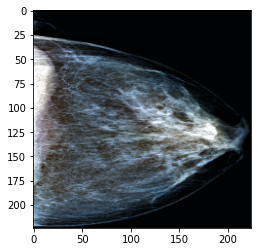

In [42]:
index = 4
print(df_train_rsna['image_path'].iloc[index])
img = Image.open(df_train_rsna['image_path'].iloc[index]) 

print(np.array(img).shape)
img_prep = process_image(df_train_rsna['image_path'].iloc[index])
plt.imshow(img_prep, cmap="gray")

./images_cmmd/D2-0230_1-3.png
(1280, 629)


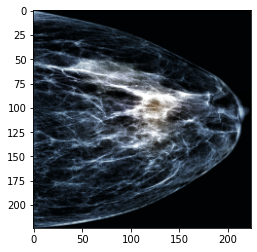

In [43]:
index = 4
print(df_train_cmmd['image_path'].iloc[index])
img = Image.open(df_train_cmmd['image_path'].iloc[index]) 

print(np.array(img).shape)
img_prep = process_image(df_train_cmmd['image_path'].iloc[index])
plt.imshow(img_prep, cmap="gray")

## Create Dataset

In [44]:
os.makedirs(SAVE_FOLDER, exist_ok=True)

df_train_cancer_rsna = df_train_rsna[df_train_rsna.cancer == 1]
df_train_healthy_rsna = df_train_rsna[(df_train_rsna.cancer == 0)]

#df_train_cancer = df_train[(df_train.cancer == 1) & (df_train.view == "CC")]
#df_train_healthy = df_train[(df_train.cancer == 0) & (df_train.view == "CC")]
df_train_implant = df_train_rsna[df_train_rsna.implant == 1]
df_train_cancer_cmmd = df_train_cmmd[df_train_cmmd.cancer == 1]

df_train_healthy_sampled_rsna = df_train_healthy_rsna.sample(n = len(df_train_cancer_rsna) + len(df_train_cancer_cmmd))

df_train_subset = pd.concat([df_train_cancer_rsna, df_train_cancer_cmmd, df_train_healthy_sampled_rsna], ignore_index = True)
print(df_train_subset.shape)
df_train_subset.head()

(10504, 20)


,site_id,patient_id,image_id,laterality,view,age,cancer,biopsy,invasive,BIRADS,implant,density,machine_id,difficult_negative_case,image_path,ID,Abnormality,Subtype,Path,Method_crop
0,1.0,10130.0,3.888120e+08,L,MLO,71.0,1,1.0,1.0,0.0,0.0,B,49.0,False,./images_rsna/10130_388811999.png,NaN,NaN,NaN,NaN,NaN
1,1.0,10130.0,6.134626e+08,L,CC,71.0,1,1.0,1.0,0.0,0.0,B,49.0,False,./images_rsna/10130_613462606.png,NaN,NaN,NaN,NaN,NaN
2,1.0,10130.0,1.360339e+09,L,CC,71.0,1,1.0,1.0,0.0,0.0,B,49.0,False,./images_rsna/10130_1360338805.png,NaN,NaN,NaN,NaN,NaN
3,1.0,10130.0,1.672637e+09,L,MLO,71.0,1,1.0,1.0,0.0,0.0,B,49.0,False,./images_rsna/10130_1672636630.png,NaN,NaN,NaN,NaN,NaN
4,1.0,10226.0,4.616148e+08,L,MLO,71.0,1,1.0,1.0,0.0,0.0,C,49.0,False,./images_rsna/10226_461614796.png,NaN,NaN,NaN,NaN,NaN


In [45]:
for image_path in tqdm(df_train_subset["image_path"]):
    patient = image_path.split('/')[-1][:-4]
    processed_img = process_image(image_path)
    cv2.imwrite(f"{SAVE_FOLDER}/{patient}.png", processed_img)

100%|██████████| 10504/10504 [03:14<00:00, 54.11it/s] 


In [46]:
df_train_subset["processed_img_path"] = SAVE_FOLDER + '/' +\
df_train_subset["image_path"].str[14:]

df_train_subset.to_csv("./output/df_train_subset.csv")